Here, we'll generate an object set with some number of classes, each class having
a different underlying distribution of poses. Objects are points living in 2D
and don't interfere with each other.

We'll reconstruct the distribution of these objects from an observed set, and use
that distribution to imagine new environments.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import scipy as sp
import scipy.stats
import time
import yaml

from pydrake.all import (RigidBodyTree, RigidBody)

In [8]:
# Generate a ton of reasonable object arrangements, or load them from a file
LOAD_PREGENERATED_ARRANGEMENTS = False
SAVE_FILE = "20180621_saved_arrangements.txt"
N_ENVIRONMENTS = 1000
N_CLASSES = 4

np.random.seed(42)

# These environments will spawn objects
# inside 1x1 unit boxes with offset [class_type % 2, class_type / 2].
# (That is, each class spawns inside its own unique box)
def generate_environment():
    environment = {}
    n_objects = np.random.randint(20)
    environment["n_objects"] = n_objects
    for k in range(n_objects):
        obj_name = "obj_%04d" % k
        environment[obj_name] = {}
        class_type = np.random.randint(N_CLASSES)
        pose = np.random.random(2) + np.array([class_type%2, class_type/2])
        environment[obj_name]["pose"] = pose.tolist()
        environment[obj_name]["class"] = class_type
    return environment

if LOAD_PREGENERATED_ARRANGEMENTS:
    with open(SAVE_FILE, "r") as f:
        environments = yaml.load(f)
    N_ENVIRONMENTS = environments["n_environments"]
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, SAVE_FILE))
else:
    # Generate arrangements
    environments = {}
    environments["n_environments"] = N_ENVIRONMENTS
    for i in range(N_ENVIRONMENTS):
        env_name = "env_%04d" % i
        environments[env_name] = generate_environment()
    with open(SAVE_FILE, "w") as f:
        yaml.dump(environments, f)
    print("Saved %d environments to file %s" % (N_ENVIRONMENTS, SAVE_FILE))

Saved 1000 environments to file 20180621_saved_arrangements.txt


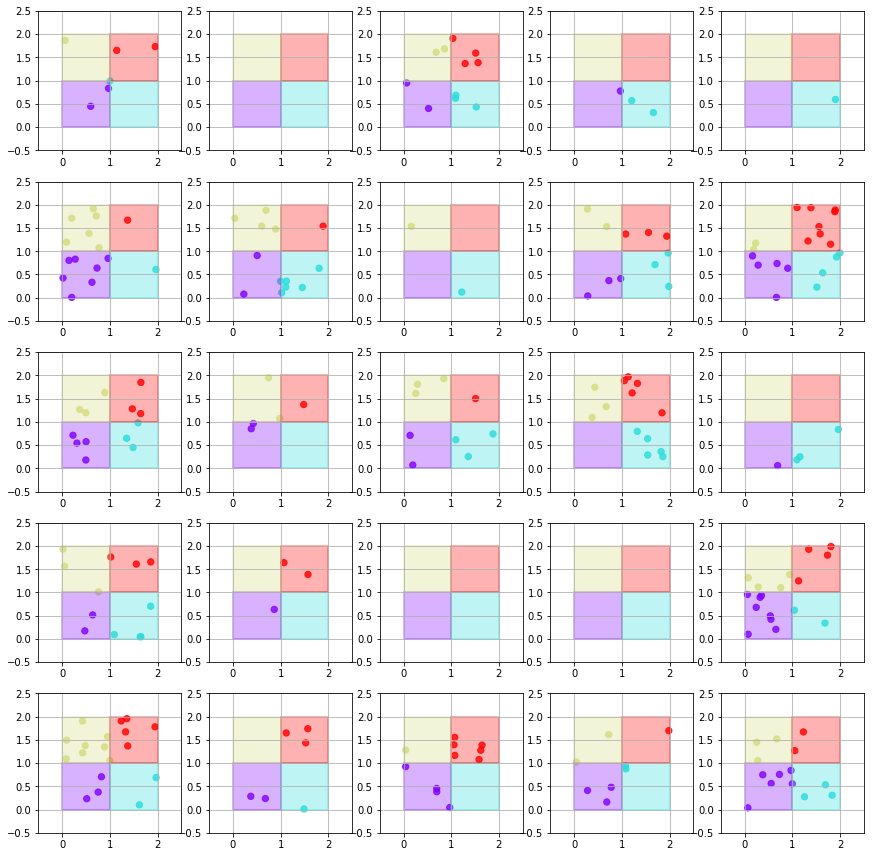

In [3]:
# Draw a few example scenes
def draw_environment(environment, ax):
    pltcolor = plt.cm.rainbow(np.linspace(0, 1, N_CLASSES))
    kr = range(environment["n_objects"])
    if len(kr) > 0:
        poses = np.vstack([environment["obj_%04d" % k]["pose"] for k in kr]).T.reshape([2, len(kr)])
        classes = [environment["obj_%04d" % k]["class"] for k in kr]
        ax.scatter(poses[0, :], poses[1, :], alpha=0.8,
                   c=[pltcolor[k] for k in classes], s=40.)
    for k in range(N_CLASSES):
        offset = np.array([k%2, k/2])
        patch = patches.Rectangle(offset, 1., 1., fill=True, color=pltcolor[k], 
                                  linestyle='solid', linewidth=2, alpha=0.3)
        ax.add_patch(patch)

plt.figure().set_size_inches(12, 12)
plt.title("Selection of environments from original distribution")
N = 5
for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments["env_%04d" % (i*N+j)], plt.gca())
        plt.grid(True)
        plt.xlim(-.5, 2.5)
        plt.ylim(-.5, 2.5)
plt.tight_layout()

## Fitting distributions to generated scene data

We're ultimately interested in sampling a number of objects $n$, a set of object classes $c_i$, and a set of object poses $p_i$ $\{[c_0, p_0], ..., [c_n, p_n]\}$.

They have joint distribution $p(n, c, p)$, which we factorize $p(n)\Pi_i\left[p(p_i | c_i)p(c_i)\right]$ -- that is, draw the number of objects and class of each object independently, and then draw each object pose independently based on a class-specific distribution.

So the distributions we need to fit are:

- The distribution of object number $p(n)$, which we'll just draw up a histogram
- The distribution of individual object class $p(c_i)$, which we'll also just draw up a histogram
- The distribution of object pose based on class $p(p_i | c_i)$, which we'll fit with KDE

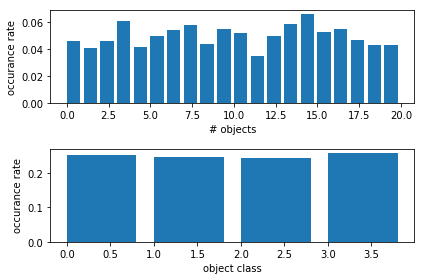

In [4]:
# Get statistics for # object occurance rate and classes
object_number_occurances = np.zeros(N_ENVIRONMENTS)
object_class_occurances = np.zeros(N_CLASSES)
for i in range(N_ENVIRONMENTS):
    env = environments["env_%04d" % i]
    object_number_occurances[i] = env["n_objects"]
    for k in range(env["n_objects"]):
        object_class_occurances[env["obj_%04d" % k]["class"]] += 1
n_hist, n_hist_bins = np.histogram(object_number_occurances,
    bins=range(int(np.ceil(np.max(object_number_occurances)))+2))
n_pdf = n_hist.astype(np.float64)/np.sum(n_hist)
plt.subplot(2, 1, 1)
plt.bar(n_hist_bins[:-1], n_pdf, align="edge")
plt.xlabel("# objects")
plt.ylabel("occurance rate")

plt.subplot(2, 1, 2)
class_pdf = object_class_occurances / np.sum(object_class_occurances)
plt.bar(range(N_CLASSES), class_pdf, align="edge")
plt.xlabel("object class")
plt.ylabel("occurance rate")
plt.tight_layout()

Computing KDE for class 0
Computing KDE for class 1
Computing KDE for class 2
Computing KDE for class 3


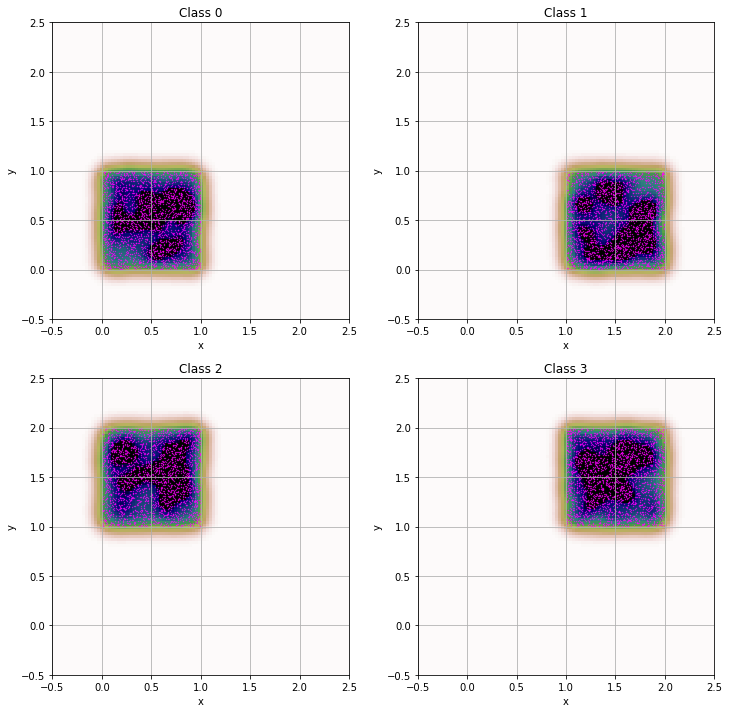

In [5]:
# Build statistics for object poses per each object class
object_poses_per_class = []
# Useful to have for preallocating occurance vectors
max_num_objects_in_any_environment = int(np.max(object_number_occurances))
for class_k in range(N_CLASSES):
    # Overallocate, we'll resize when we're done
    poses = np.zeros((2, max_num_objects_in_any_environment*N_ENVIRONMENTS))
    total_num_objects = 0
    for i in range(N_ENVIRONMENTS):
        env = environments["env_%04d" % i]
        for k in range(env["n_objects"]):
            obj = env["obj_%04d" % k]
            if obj["class"] == class_k:
                poses[:, total_num_objects] = obj["pose"][:]
                total_num_objects += 1
    object_poses_per_class.append(poses[:, :total_num_objects])

class_kde_fits = []
plt.figure().set_size_inches(12, 12)
plt.title("Distribution over space, per object class")
for class_k in range(N_CLASSES):
    print("Computing KDE for class %d" % class_k)
    poses = object_poses_per_class[class_k]
    kde_fit = sp.stats.gaussian_kde(poses)
    class_kde_fits.append(kde_fit)
    
    xmin = -0.5
    xmax = 2.5
    ymin = -.5
    ymax = 2.5
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kde_fit(positions).T, X.shape)

    plt.subplot(2, 2, class_k+1)
    plt.title("Class %d" % class_k)
    plt.gca().imshow(np.rot90(Z), vmin=0., vmax=1.,
                     cmap=plt.cm.gist_earth_r,
                     extent=[xmin, xmax, ymin, ymax])
    plt.scatter(poses[0, :], poses[1, :], s=0.1, c=[1., 0., 1.])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

## Sampling new scenes from this data

We can generate new scenes by sampling up the dependency tree:

1) First sample # of objects

2) Then sample a class for every object, independently

3) Given each object's class, sample its location

We can also evaluate the likelihood of each generated sample
to get an idea how "typical" they are, by finding the likelihood
of each object given its generated position and class and combining
them. However, we have to normalize by the maximum possible likelihood
for an object of that class for every object for the comparison between
two sets of objects to make sense.

Classwise max likelihoods:  [1.16897493 1.21107958 1.17524572 1.19238163]
TODO: Log likelihood is still probably wrong... the scaling with N is weird.


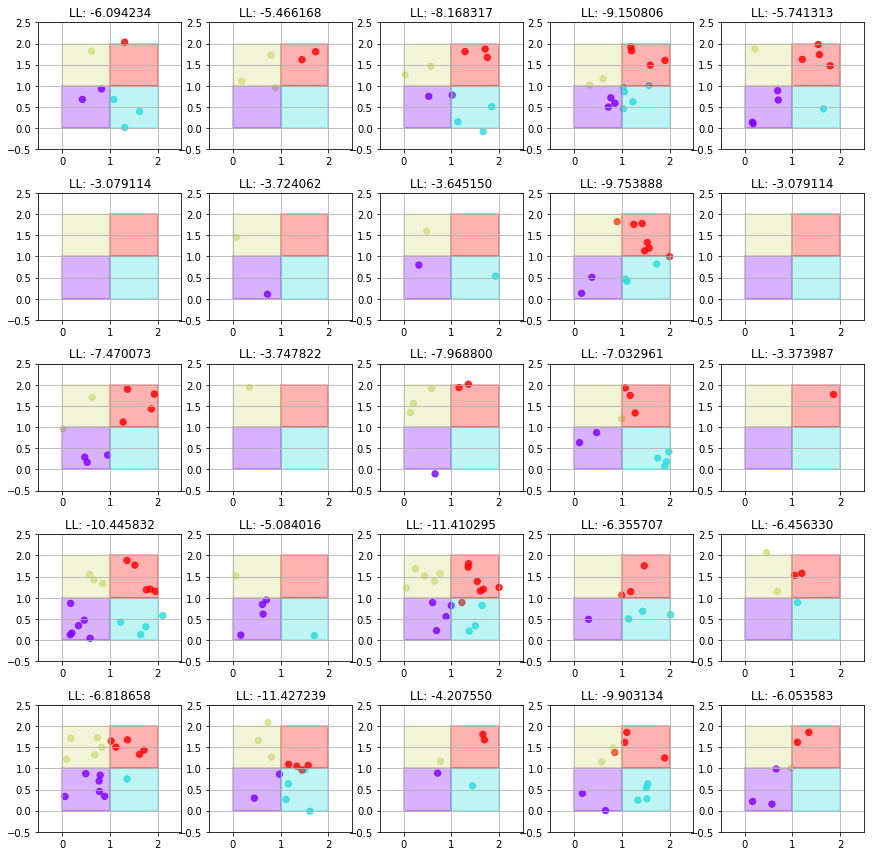

In [6]:
n_cdf = np.cumsum(n_pdf)
class_cdf = np.cumsum(class_pdf)

# Calculate maximum likelihood value for each class
classwise_max_likelihoods = np.zeros(N_CLASSES)
for i in range(N_CLASSES):
    # Evaluate the PDF at a bunch of sample points
    xmin = -0.5
    xmax = 2.5
    ymin = -0.5
    ymax = 2.5
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    classwise_max_likelihoods[i] = (np.max(class_kde_fits[i](positions)))

print "Classwise max likelihoods: ", classwise_max_likelihoods

plt.figure().set_size_inches(12, 12)
plt.title("Generated environments matching original distribution")
np.random.seed(42)
N = 5
for i in range(N):
    for j in range(N):
        total_log_likelihood = 0.
        n_objects = np.argmax(n_cdf >= np.random.random())
        total_log_likelihood += np.log(n_pdf[n_objects])
        environment = {"n_objects": n_objects}
        lln = 0
        for object_k in range(n_objects):
            obj_name = "obj_%04d" % object_k
            obj_class = np.argmax(class_cdf >= np.random.random())
            total_log_likelihood += np.log(class_pdf[obj_class] / np.max(class_pdf))
            obj_pose = class_kde_fits[obj_class].resample([1]).T
            total_log_likelihood += (class_kde_fits[obj_class].logpdf(obj_pose) -
                                     np.log(classwise_max_likelihoods[obj_class]))
            environment[obj_name] = {"pose": obj_pose,
                                     "class": obj_class}
        
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environment, plt.gca())
        plt.grid(True)
        plt.title("LL: %f" % total_log_likelihood)
        plt.xlim(-0.5, 2.5)
        plt.ylim(-0.5, 2.5)

print "TODO: Log likelihood is still probably wrong... the scaling with N is weird."
plt.tight_layout()

As is visible above, this technique generates reasonable looking scenes. It does, however, generate "impossible" scenes (placing objects slightly out of bounds) with some regularity, since the KDE doesn't capture the sharp edge of the feasible set of object poses.

I attempt to calculate log likelihood scores for each arrangement by calculating

$$ p(c, p, n) = p(n) * {\Large \Pi_{i}^{n}} \left[ \dfrac{p(p_i | c_i)}{\max_{\hat{p}}{p(\hat{p} | c_i})} \dfrac{p(c_i)}{\max_{\hat{c}} p(c)} \right] $$ 

(which includes normalization on a per-object and per-class basis to make comparison between scenes with different N possible). But I'm not convinced this is right, yet...